# <center>Classifying social media post popularity<center>
    
<center>Created by Zsófia Rebeka Katona<center>
<center>Data Science 2 - Kaggle competition<center>


## Introduction
---

The goal of this challenge is to predict which articles are shared the most on social media. The data comes from the website mashable.com as of the beginning of 2015. The dataset used in the competition can be found in the UCI repository.

- You will find the training and test data in the data section of the competition, along with a description of the features. - You will need to build models on the training data and make predictions on the test data and submit your solutions to Kaggle. You will also find a sample solution file in the data section that shows the format you will need to use for your own submissions.
- The deadline for Kaggle solutions is 8PM on 19 April. You will be graded primarily on the basis of your work and how clearly you explain your methods and results. Those in the top three in the competition will receive some extra points. I expect you to experiment with all the methods we have covered: linear models, random forest, gradient boosting, neural networks + parameter tuning, feature engineering.
- You will see the public score of your best model on the leaderboard. A private dataset will be used to evaluate the final performance of your model to avoid overfitting based on the leaderboard.
- You should also submit to Moodle the documentation (ipynb and pdf) of your work, including exploratory data analysis, data cleaning, parameter tuning and evaluation. Aim for concise explanations.
- Feel free to ask questions about the task in Slack. The Kaggle competition is already open, please start working on it and submitting solutions (you cannot submit more than 5 solutions per day).

## Data import
---

In [1]:
# Importing required libraries
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import xgboost as xgb
import warnings


from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling1D, Rescaling, Reshape
from keras.models import Model, Sequential, clone_model
from keras.optimizers import Adam
from keras.utils import set_random_seed, to_categorical
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression, Ridge, ElasticNet
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, auc, confusion_matrix, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from xgboost import XGBRegressor

In [2]:
# Importing the training and the test set
current_dir = os.getcwd()
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Checking the attributes of the sets
print(f"The shape of the train set is: {train_df.shape}.")
print(f"The shape of the test set is {test_df.shape}.")
print("The data types of the train set:")
train_df.info()

The shape of the train set is: (29733, 61).
The shape of the test set is (9911, 60).
The data types of the train set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  f

## Exploratory Data Analysis
---

In [3]:
# Checking the dataset
train_df.head(10)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.100000,0.000000,0.000000,0.500000,0.000000,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.100000,0.000000,0.000000,0.500000,0.000000,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.050000,0.000000,0.000000,0.500000,0.000000,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.400000,0.000000,0.000000,0.500000,0.000000,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.050000,0.000000,0.000000,0.500000,0.000000,0,7
5,568,7,126,0.723577,1.0,0.774194,3,3,1,0,...,0.285714,0.000000,0.0,0.000000,0.454545,0.136364,0.045455,0.136364,0,8
6,318,12,1422,0.367994,1.0,0.469256,28,28,26,0,...,0.700000,-0.234167,-0.5,-0.050000,1.000000,0.100000,0.500000,0.100000,0,9
7,582,6,1102,0.451287,1.0,0.642089,7,3,1,0,...,0.800000,-0.151630,-0.4,-0.050000,0.800000,0.400000,0.300000,0.400000,1,11
8,269,9,0,0.000000,0.0,0.000000,0,0,5,0,...,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0,12
9,567,7,94,0.755319,1.0,0.812500,8,6,0,11,...,1.000000,-0.183333,-0.2,-0.166667,0.000000,0.000000,0.500000,0.000000,0,14


In [4]:
# Filtering for missing values
train_df.isnull().sum().sum()

0

In [5]:
# Filtering for NA values
train_df.isna().sum().sum()

0

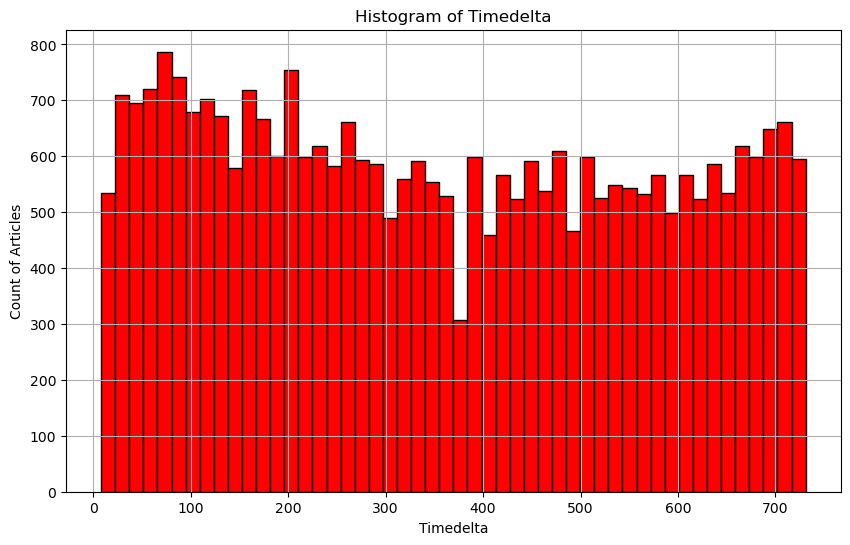

In [6]:
# Plotting the distribution of days elapsed between the article publication and the dataset acquisition
plt.figure(figsize=(10, 6))
plt.hist(train_df['timedelta'], bins=50, color='red', edgecolor='black')
plt.xlabel('Timedelta')
plt.ylabel('Count of Articles')
plt.title('Histogram of Timedelta')
plt.grid(True)
plt.show()

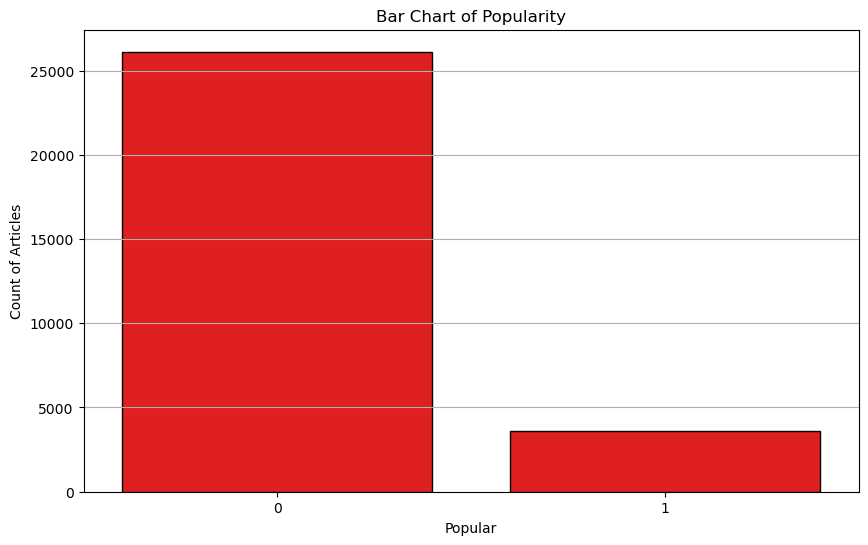

In [7]:
# Plotting the distribution of popularity
plt.figure(figsize=(10, 6))
sns.countplot(x='is_popular', data=train_df, color='red', edgecolor='black')
plt.xlabel('Popular')
plt.ylabel('Count of Articles')
plt.title('Bar Chart of Popularity')
plt.grid(True, axis='y')
plt.show()

In [8]:
# Checking the number of popular and not popular articles
train_df.value_counts("is_popular")

is_popular
0    26116
1     3617
dtype: int64

We can observe that there are significantly more unpopular articles than popular. Namely, 12% of the total articles are popular.

#### Train-test split

In [9]:
# Dropping the target variable from the training set
features = train_df.drop(columns=["is_popular"])
label = train_df["is_popular"]

# Setting the random state
prng = np.random.RandomState(20240419)

# Splitting the fata
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

#### Feature engineering

In [10]:
# Adding the total number of media elements in each post (links, videos, images)
train_df['total_multimedia'] = train_df['num_hrefs'] + train_df['num_self_hrefs'] + train_df['num_imgs'] + train_df['num_videos']

# Combining 'easy-to-consume' topics to represent the dominant topic of the article
train_df['easy_to_consume'] = train_df['data_channel_is_socmed'] + train_df['data_channel_is_entertainment'] + train_df['data_channel_is_lifestyle']

# Combining more specific topics
train_df['specific_to_consume'] = train_df['data_channel_is_bus'] + train_df['data_channel_is_tech'] + train_df['data_channel_is_world']

# Selecting features for feature engineering
features_fe = train_df[['total_multimedia', 'easy_to_consume', 'specific_to_consume']]

# Labelling the count column
label = train_df["is_popular"]

# Setting the random pseudo state again
prng = np.random.RandomState(20240419)

# Splitting the feature engineered training set and test set again
X_train_fe, X_test_fe, y_train, y_test = train_test_split(features_fe, label, test_size=0.2, random_state=prng)

## Data cleaning
---

## Predictive models
---

In [11]:
# Defining the loss function (root mean squared logarithmic error)
def calculateRMSLE(prediction, y_obs):
    """
    Calculate the Root Mean Squared Logarithmic Error (RMSLE)
    between the predicted values and the observed values.

    Parameters:
    - prediction: array-like, the predicted values.
    - y_obs: array-like, the observed (true) values.

    Returns:
    - float: the RMSLE value rounded to four decimal places.
    """
    return round(np.sqrt(
        np.mean(
                (
                    np.log(np.where(prediction < 0, 0, prediction) + 1) -
                    np.log(y_obs + 1)
                )**2
        )
    ), 4)

### Model 1: Linear models

In [12]:
# Setting the pipeline for the linear model
model1 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), X_train.columns)
    ])),
    ('regressor', LinearRegression())
])

# Fitting the model
model1.fit(X_train, y_train)

# Calculating the train error
train_error_lin = calculateRMSLE(model1.predict(X_train), y_train)

# Calculating the test error
test_error_lin = calculateRMSLE(model1.predict(X_test), y_test)

# Displaying the results
model_results = pd.DataFrame({"Model": ["Model 1 (Linear)"], "Train Error": [train_error_lin], "Test Error": [test_error_lin]})
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237


### Model 2: Logit models (Lasso)
Using the same 6 different models
Logit + lasso with CV + Feature Engineered

In [13]:
# Defining the pipeline for the logistic regression model
model2 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), X_train.columns)
    ])),
    ('classifier', LogisticRegression(random_state=prng))
])

# Fitting the model
model2.fit(X_train, y_train)

# Calculating the train error
train_error_model2 = calculateRMSLE(model2.predict(X_train), y_train)
# Calculating the test error
test_error_model2 = calculateRMSLE(model2.predict(X_test), y_test)

# Displaying the results
new_results_model2 = pd.DataFrame({'Model': ['Model 2 (Logistic)'], 
                            'Train Error': [train_error_model2], 
                            'Test Error': [test_error_model2]})
model_results = pd.concat([model_results, new_results_model2], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435


### Model 3: Flexible linear with polynomial features

In [14]:
# Creating a the flexible linar pipeline with 2 degree polynomials
steps = [
    ("scaling", StandardScaler()),
    ("2_degree_poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ols", LinearRegression())
]
model3 = Pipeline(steps)

# Fitting the flexible pipe on the training data
model3.fit(X_train, y_train)

# Calculating the train error
train_error_model3 = calculateRMSLE(model3.predict(X_train), y_train)

# Calculating the test error
test_error_model3 = calculateRMSLE(model3.predict(X_test), y_test)

# Displaying the results
new_results_model3 = pd.DataFrame({'Model': ['Model 3 (Polynomial linear)'], 
                            'Train Error': [train_error_model3], 
                            'Test Error': [test_error_model3]})
model_results = pd.concat([model_results, new_results_model3], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708


### Model 4: Decision Trees

In [15]:
# Creating the decision tree pipeline
steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=5, random_state=prng))
]
model4 = Pipeline(steps)

# Fitting the training data
model4.fit(X_train, y_train)

# Calculating the train error
train_error_model4 = calculateRMSLE(model4.predict(X_train), y_train)

# Calculating the test error
test_error_model4 = calculateRMSLE(model4.predict(X_test), y_test)

# Displaying the results
new_results_model4 = pd.DataFrame({'Model': ['Model 4 (Decision tree)'], 
                            'Train Error': [train_error_model4], 
                            'Test Error': [test_error_model4]})
model_results = pd.concat([model_results, new_results_model4], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265


### Model 5: Improved decision tree

In [16]:
# Creating the improved decision tree pipeline
steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=10, random_state=prng))
]
model5 = Pipeline(steps)

# Fitting the training data
model5.fit(X_train, y_train)

# Calculating the train error
train_error_model5 = calculateRMSLE(model5.predict(X_train), y_train)

# Calculating the test error
test_error_model5 = calculateRMSLE(model5.predict(X_test), y_test)

# Displaying the results
new_results_model5 = pd.DataFrame({'Model': ['Model 5 (Improved Decision tree)'], 
                            'Train Error': [train_error_model5], 
                            'Test Error': [test_error_model5]})
model_results = pd.concat([model_results, new_results_model5], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489


### Model 6: RandomForest

In [17]:
# Creating a pipeline for RandomForest
steps = [
    ("rf", RandomForestRegressor(n_estimators=100, random_state=prng))
]
model6 = Pipeline(steps)

# Fitting the training data
model6.fit(X_train, y_train)

# Calculating the train error
train_error_model6 = calculateRMSLE(model6.predict(X_train), y_train)

# Calculating the test error
test_error_model6 = calculateRMSLE(model6.predict(X_test), y_test)

# Displaying the results
new_results_model6 = pd.DataFrame({'Model': ['Model 6 (Random Forest)'], 
                            'Train Error': [train_error_model6], 
                            'Test Error': [test_error_model6]})
model_results = pd.concat([model_results, new_results_model6], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298


### Model 7: Improved RandomForest

In [18]:
# Setting a timer to measure the running time
start_time = time.time()

# Define the number of folds
k_folds = 5 

# Create a KFold cross-validation splitter
kf = KFold(n_splits=k_folds, shuffle=True, random_state=prng)

# Define preprocessing steps
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Defiing the RandomForest pipeline with 100 estimators
model7 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=prng))
])

# Fitting the model
model7.fit(X_train, y_train)

# Defining a custom scorer
def rmsle_scorer(estimator, X, y):
    prediction = estimator.predict(X)
    return calculateRMSLE(prediction, y)

# Performing cross-validation
cv_scores = cross_validate(model7, X_train, y_train, cv=kf, scoring=rmsle_scorer)

# Calculating the error on training set
train_error_model7 = calculateRMSLE(model7.predict(X_train), y_train)

# Calculating the error on test set
test_error_model7 = calculateRMSLE(model7.predict(X_test), y_test)

# Displaying the results and the run time
new_results_model7 = pd.DataFrame({'Model': ['Model 7 (Improved Random Forest)'], 
                            'Train Error': [train_error_model7], 
                            'Test Error': [test_error_model7]})
model_results = pd.concat([model_results, new_results_model7], ignore_index=True)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))
model_results

Execution time: 550.65 seconds


,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302


### Model 8: Explainable Gradient Boosting

In [19]:
# Defining the pipeline for Gradient Boosting
model8 = Pipeline([
    ('xgb_model', xgb.XGBRegressor(enable_categorical=True))
])

# Fitting the pipeline
model8.fit(X_train, y_train)

# Calculating the training error
train_error_model8 = calculateRMSLE(model8.predict(X_train), y_train)

# Calculating the test error
test_error_model8 = calculateRMSLE(model8.predict(X_test), y_test)

# Displaying the results
new_results_model8 = pd.DataFrame({'Model': ['Model 8 (Gradient Boosting)'], 
                            'Train Error': [train_error_model8], 
                            'Test Error': [test_error_model8]})
model_results = pd.concat([model_results, new_results_model8], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377


### Model 9: Improved Explainable Gradient Boosting
Adding StandardScaler and lasso regularization

In [20]:
# Defining the pipeline for XGB
model9 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), X_train.columns)
    ])),
    ('regressor', XGBRegressor(enable_categorical=True, objective='reg:squarederror', random_state=20240419))
])

# Defining the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
}

# Initializing the GridSearchCV object
grid_search = GridSearchCV(estimator=model9, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Performing grid search
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Updating the model with the best hyperparameters
model9.set_params(**best_params)

# Fitting the pipeline with the best hyperparameters
model9.fit(X_train, y_train)

# Calculating the training error
train_error_model9 = calculateRMSLE(model9.predict(X_train), y_train)

# Calculating the test error
test_error_model9 = calculateRMSLE(model9.predict(X_test), y_test)

# Displaying the results
new_results_model9 = pd.DataFrame({'Model': ['Model 9 (Improved Gradient Boosting)'], 
                            'Train Error': [train_error_model9], 
                            'Test Error': [test_error_model9]})
model_results = pd.concat([model_results, new_results_model9], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220


In [39]:
# Defining the pipeline with StandardScaler, Regularization, and XGBoost model
model9 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), X_train_fe.columns)
    ])),
    ('regressor', XGBRegressor(enable_categorical=True, objective='reg:squarederror', random_state=20240419))
])

# Defining the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
}

# Initializing the GridSearchCV object
grid_search = GridSearchCV(estimator=model9, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Performing grid search
grid_search.fit(X_train_fe, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Updating the model with the best hyperparameters
model9.set_params(**best_params)

# Fitting the pipeline with the best hyperparameters
model9.fit(X_train_fe, y_train)

# Calculating the training error
train_error_model9 = calculateRMSLE(model9.predict(X_train_fe), y_train)

# Calculating the test error
test_error_model9 = calculateRMSLE(model9.predict(X_test_fe), y_test)

# Displaying the results
new_results_model9 = pd.DataFrame({'Model': ['Model 9 (Improved Gradient Boosting with FE)'], 
                            'Train Error': [train_error_model9], 
                            'Test Error': [test_error_model9]})
model_results = pd.concat([model_results, new_results_model9], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


## Neural networks
---

### Model 10
Simple fully connected layer network with dropout

In [21]:
# Setting the simple network
model10 = Sequential([
    Rescaling(1./255, input_shape=(60,)),
    Flatten(), 
    Dense(256, activation='relu'),
    # Adding a Dropout of 0.5
    Dropout(0.5),
    # Output shape adjusted to the binary target variable
    Dense(1, activation='sigmoid')
])

# Compiling the model
model10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model10.summary())

C:\Users\Zsófi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,873 (62.00 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Training the model
history10 = model10.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7746 - loss: 33.1052 - val_accuracy: 0.8735 - val_loss: 0.6317
Epoch 2/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8540 - loss: 0.6359 - val_accuracy: 0.8700 - val_loss: 0.4887
Epoch 3/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8618 - loss: 0.5430 - val_accuracy: 0.8774 - val_loss: 0.4342
Epoch 4/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8701 - loss: 0.4644 - val_accuracy: 0.8772 - val_loss: 0.3817
Epoch 5/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8764 - loss: 0.4013 - val_accuracy: 0.8767 - val_loss: 0.3876
Epoch 6/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8773 - loss: 0.3940 - val_accuracy: 0.8774 - val_loss: 0.3725
Epoch 7/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8794 - loss: 0.3766 - val_accuracy: 0.8769 - val_loss: 0.3718
Epoch 8/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8746 - loss: 0.3772 - val_accuracy: 0

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Predictions on the training set
    y_train_pred = model.predict(X_train).flatten()

    # Predictions on the test set
    y_test_pred = model.predict(X_test).flatten()

    # Calculate RMSLE for the training set
    train_rmsle = calculateRMSLE(y_train_pred, y_train)

    # Calculate RMSLE for the test set
    test_rmsle = calculateRMSLE(y_test_pred, y_test)

    # Displaying the results
    new_results = pd.DataFrame({'Model': [model_name], 
                                'Train Error': [train_rmsle], 
                                'Test Error': [test_rmsle]})
    return new_results

# Evaluating the model
new_results_model10 = evaluate_model(model10, X_train, y_train, X_test, y_test, 'Model 10 (Simple network with dropouts)')
model_results = pd.concat([model_results, new_results_model10], ignore_index=True)
model_results

744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


### Model 11
Convolutional neural network with dropout

In [24]:
# Setting the CNN network
model11 = Sequential([
    Rescaling(1./255, input_shape=(60, 1)),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model11.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model11.summary())

C:\Users\Zsófi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 58, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 27, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 832)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         213,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,841 (858.75 KB)

 Trainable params: 219,841 (858.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
# Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Training the model
history11 = model11.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8338 - loss: 4.9632 - val_accuracy: 0.8754 - val_loss: 0.3858
Epoch 2/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8773 - loss: 0.3935 - val_accuracy: 0.8769 - val_loss: 0.3957
Epoch 3/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8752 - loss: 0.3901 - val_accuracy: 0.8774 - val_loss: 0.3656
Epoch 4/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8781 - loss: 0.3827 - val_accuracy: 0.8772 - val_loss: 0.3652
Epoch 5/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8779 - loss: 0.3769 - val_accuracy: 0.8774 - val_loss: 0.3728
Epoch 6/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8769 - loss: 0.3770 - val_accuracy: 0.8774 - val_loss: 0.3623
Epoch 7/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8816 - loss: 0.3619 - val_accuracy: 0.8774 - val_loss: 0.3609
Epoch 8/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8777 - loss: 0.3666 - val_accuracy: 0

In [26]:
# Evaluating the model
new_results_model11 = evaluate_model(model11, X_train, y_train, X_test, y_test, 'Model 11 (Convolutional neural network with dropout)')
model_results = pd.concat([model_results, new_results_model11], ignore_index=True)
model_results

744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


### Model 12

In [27]:
# Setting the network
model12 = Sequential([
    Rescaling(1./255, input_shape=(60,)),
    Flatten(), 
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model12.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model12.summary())

C:\Users\Zsófi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,833 (222.00 KB)

 Trainable params: 56,833 (222.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
# Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Training the model
history12 = model12.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7712 - loss: 45.2807 - val_accuracy: 0.8774 - val_loss: 0.4356
Epoch 2/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8464 - loss: 1.1613 - val_accuracy: 0.8774 - val_loss: 0.3979
Epoch 3/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8729 - loss: 0.5385 - val_accuracy: 0.8774 - val_loss: 0.3920
Epoch 4/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8741 - loss: 0.4532 - val_accuracy: 0.8774 - val_loss: 0.3763
Epoch 5/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8713 - loss: 0.4233 - val_accuracy: 0.8774 - val_loss: 0.3728
Epoch 6/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8816 - loss: 0.3886 - val_accuracy: 0.8774 - val_loss: 0.3721
Epoch 7/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8784 - loss: 0.3874 - val_accuracy: 0.8774 - val_loss: 0.3720
Epoch 8/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8795 - loss: 0.3791 - val_accuracy: 0

In [29]:
# Evaluating the model
new_results_model12 = evaluate_model(model12, X_train, y_train, X_test, y_test, 'Model 12 (Increased width with dropouts)')
model_results = pd.concat([model_results, new_results_model12], ignore_index=True)
model_results

744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


### Model 13
Simple fully connected neural network with increased dropout, and an additional learning rate for adam

In [30]:
# Setting the network
model13 = Sequential([
    Flatten(input_shape=(60,)),
    Dense(64, activation='relu'),
    Dropout(0.6),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.6),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Defining the optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0001)

# Compiling the model
model13.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model13.summary())

C:\Users\Zsófi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,401 (25.00 KB)

 Trainable params: 6,209 (24.25 KB)

 Non-trainable params: 192 (768.00 B)

None


In [31]:
# Defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Training the model
history13 = model13.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5381 - loss: 0.8272 - val_accuracy: 0.8699 - val_loss: 0.4919
Epoch 2/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6675 - loss: 0.6382 - val_accuracy: 0.8735 - val_loss: 0.4274
Epoch 3/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7683 - loss: 0.5336 - val_accuracy: 0.8741 - val_loss: 0.3925
Epoch 4/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8218 - loss: 0.4712 - val_accuracy: 0.8747 - val_loss: 0.3792
Epoch 5/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8489 - loss: 0.4330 - val_accuracy: 0.8752 - val_loss: 0.3746
Epoch 6/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8648 - loss: 0.4125 - val_accuracy: 0.8757 - val_loss: 0.3753
Epoch 7/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8738 - loss: 0.3997 - val_accuracy: 0.8752 - val_loss: 0.3758
Epoch 8/25
744/744 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8756 - loss: 0.3934 - val_accuracy: 0.

In [32]:
# Evaluating the model
new_results_model13 = evaluate_model(model13, X_train, y_train, X_test, y_test, 'Model 13 (NN with learning rate and increased dropouts)')
model_results = pd.concat([model_results, new_results_model13], ignore_index=True)
model_results

744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


## Improving linear models
---
Picking my best performing linear models and adding further improvements, such as regularization methods

### Model 14
Logistic model with Ridge regularization

In [33]:
# Defining the pipeline for the logistic regression model with L2 regularization
model14 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), X_train.columns)
    ])),
    ('classifier', LogisticRegression(penalty='l2', C=0.0002, random_state=prng))
])

# Fitting the model
model14.fit(X_train, y_train)

# Calculating the train error
train_error_log_l2 = calculateRMSLE(model14.predict(X_train), y_train)

# Calculating the test error
test_error_log_l2 = calculateRMSLE(model14.predict(X_test), y_test)

# Displaying the results
new_results_log_l2 = pd.DataFrame({'Model': ['Model 14 (Logistic with L2 Regularization)'], 
                                   'Train Error': [train_error_log_l2], 
                                   'Test Error': [test_error_log_l2]})
model_results = pd.concat([model_results, new_results_log_l2], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


### Model 15
Linear model with Ridge regularization

In [34]:
# Setting the pipeline for the Ridge regression model
model15 = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), X_train.columns)
    ])),
    ('regressor', Ridge(alpha=1))
])

# Fitting the model
model15.fit(X_train, y_train)

# Calculating the train error
train_error_linear_ridge = calculateRMSLE(model15.predict(X_train), y_train)

# Calculating the test error
test_error_linear_ridge = calculateRMSLE(model15.predict(X_test), y_test)

# Displaying the results
new_results_linear_ridge = pd.DataFrame({"Model": ["Model 15 (Linear model with Ridge)"], 
                                    "Train Error": [train_error_linear_ridge], 
                                    "Test Error": [test_error_linear_ridge]})

model_results = pd.concat([model_results, new_results_linear_ridge], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


### Model 16
Linear model with Ridge regularization and using cross-validation

In [35]:
# Defining the parameter grid for alpha values
param_grid = {'regressor__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# Initializing the GridSearchCV object
grid_search = GridSearchCV(estimator=model15, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Performing grid search
grid_search.fit(X_train, y_train)

# Getting the best alpha
best_alpha = grid_search.best_params_['regressor__alpha']

# Updating the model with the best alpha value
model16 = model15.set_params(regressor__alpha=best_alpha)

# Fitting the model with the best alpha value
model16.fit(X_train, y_train)

# Calculate the train and test errors
train_error_ridge_best = calculateRMSLE(model16.predict(X_train), y_train)
test_error_ridge_best = calculateRMSLE(model16.predict(X_test), y_test)

# Display the results
new_results_model16 = pd.DataFrame({"Model": ["Model 16 (Linear model with Ridge - Best Alpha)"], 
                                         "Train Error": [train_error_ridge_best], 
                                         "Test Error": [test_error_ridge_best]})
model_results = pd.concat([model_results, new_results_model16], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


### Model 17
Linear model with ElasticNet, using cross-validation

In [36]:
# Defining ElasticNet model
elastic_net = ElasticNet()

# Define hyperparameters grid for tuning
param_grid = {
    'alpha': [0.1, 1, 10, 25, 50],
    'l1_ratio': [0.0001, 0.001, 0.1, 0.5, 0.9]
}

# Performing grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

# Train the ElasticNet model with the best hyperparameters
model17 = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
model17.fit(X_train, y_train)

# Calculating the train and test errors
train_error_model17 = calculateRMSLE(model17.predict(X_train), y_train)
test_error_model17 = calculateRMSLE(model17.predict(X_test), y_test)

# Display the results
new_results_model17 = pd.DataFrame({"Model": ["Model 17 (Linear model with ElasticNet - Best Alpha)"], 
                                         "Train Error": [train_error_model17], 
                                         "Test Error": [test_error_model17]})
model_results = pd.concat([model_results, new_results_model17], ignore_index=True)
model_results

,Model,Train Error,Test Error
0,Model 1 (Linear),0.2222,0.2237
1,Model 2 (Logistic),0.2419,0.2435
2,Model 3 (Polynomial linear),0.2097,0.5708
3,Model 4 (Decision tree),0.2205,0.2265
4,Model 5 (Improved Decision tree),0.1925,0.2489
5,Model 6 (Random Forest),0.0804,0.2298
6,Model 7 (Improved Random Forest),0.0804,0.2302
7,Model 8 (Gradient Boosting),0.1322,0.2377
8,Model 9 (Improved Gradient Boosting),0.2140,0.2220
9,Model 10 (Simple network with dropouts),0.2249,0.2264


## Evaluation
---

#### Predictive models:
After analyzing the final results table, I concluded that the simple model yields the lowest RMSLE results. As my best model was the simplest model, I tried to improve it further with several regularization techniques, such as Ridge, Lasso and ElasticNet, and used cross-validation to find the best regularization parameters. For most of these improved models, the model produced very similar RMSLE scores. I have found that my first linear model with Ridge regression already uses the best parameters, hence the cross-validation in the linear models have not improved the model. ElasticNet produced different prediction results.
Considering the other models, RandomForest and GradientBoosting yielded the best training RMSLE results.. Using StandardScaler improved my RandomForest model, however it largely overfitted my decision tree. Despite producing better training RMSLE scores, the model produced worse test error scores.
The similar thing happened using polynomials. Due to the large number of predictors, the 3 and 4 degree polynomials increased the computational intensity and the significantly increases the run time. I also experimented wuth grouped variables, but it I got higher train and test error scores, therefore I opted to drop them.

#### Neural networks:
When I was experimenting with different neural networks, I have found that including MaxPooling and several convolutional layers deteriorates the models, therefore I didn't include them.
After experimenting with several dropout values, I have noticed that as soon as I increased the dropout from 0.4 to 0.6, the training and test errors went from 0.66 to 0.22. By dropping out more neurons during training, models performed better in terms of generalization and is less likely to overfit the training data. However, they still didn"t achieve better scores than the improved gradient boosting model. It might be due to the reason that simpler models may perform better than complex neural networks, especially if the dataset is not large or complex enough (like images) to benefit from the additional capacity of the neural networks.

#### Final model:

In [37]:
def save_predictions(model, test_df, model_number):
    # Making predictions using the specified model
    scores = model.predict(test_df)
    
    # Getting the article_id column from test_df
    article_ids = test_df['article_id']
    
    # Creating the dataframe for the predictions
    df = pd.DataFrame({'article_id': article_ids, 'score': scores})
    
    # Save predictions to a CSV file
    df.to_csv(f'predictions_model{model_number}.csv', index=False)

# Example usage:
save_predictions(model9, test_df, 9)

In [38]:
# Defining variable sets
textvars = ["n_tokens_content", "n_unique_tokens", "n_non_stop_words", "n_non_stop_unique_tokens",
            "average_token_length", "num_keywords"]
mediavars = ["num_hrefs", "num_self_hrefs", "num_imgs", "num_videos"]
topicvars = ["data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus",
             "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"]
keywordvars = ["kw_min_min", "kw_max_min", "kw_avg_min", "kw_avg_min", "kw_max_max", "kw_avg_max", "kw_min_avg",
               "kw_max_avg", "kw_avg_avg"]
socmedvars = ["self_reference_min_shares", "self_reference_max_shares", "self_reference_avg_sharess"]
timevars = ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
            'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
            'weekday_is_sunday', 'is_weekend']
sentimentvars = [
    'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
    'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words',
    'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
    'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity',
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity']

# Create squared versions of variables
squared_textvars = ['{}_squared'.format(var) for var in textvars]
squared_mediavars = ['{}_squared'.format(var) for var in mediavars]
squared_topicvars = ['{}_squared'.format(var) for var in topicvars]
squared_keywordvars = ['{}_squared'.format(var) for var in keywordvars]
squared_socmedvars = ['{}_squared'.format(var) for var in socmedvars]
squared_timevars = ['{}_squared'.format(var) for var in timevars]
squared_sentimentvars = ['{}_squared'.format(var) for var in sentimentvars]

# Print squared variables
print("Squared Text Variables:", squared_textvars)
print("Squared Media Variables:", squared_mediavars)
print("Squared Topic Variables:", squared_topicvars)
print("Squared Keyword Variables:", squared_keywordvars)
print("Squared Socmed Variables:", squared_socmedvars)
print("Squared Time Variables:", squared_timevars)
print("Squared Sentiment Variables:", squared_sentimentvars)

Squared Text Variables: ['n_tokens_content_squared', 'n_unique_tokens_squared', 'n_non_stop_words_squared', 'n_non_stop_unique_tokens_squared', 'average_token_length_squared', 'num_keywords_squared']
Squared Media Variables: ['num_hrefs_squared', 'num_self_hrefs_squared', 'num_imgs_squared', 'num_videos_squared']
Squared Topic Variables: ['data_channel_is_lifestyle_squared', 'data_channel_is_entertainment_squared', 'data_channel_is_bus_squared', 'data_channel_is_socmed_squared', 'data_channel_is_tech_squared', 'data_channel_is_world_squared']
Squared Keyword Variables: ['kw_min_min_squared', 'kw_max_min_squared', 'kw_avg_min_squared', 'kw_avg_min_squared', 'kw_max_max_squared', 'kw_avg_max_squared', 'kw_min_avg_squared', 'kw_max_avg_squared', 'kw_avg_avg_squared']
Squared Socmed Variables: ['self_reference_min_shares_squared', 'self_reference_max_shares_squared', 'self_reference_avg_sharess_squared']
Squared Time Variables: ['weekday_is_monday_squared', 'weekday_is_tuesday_squared', 'w